In [27]:
# PROJECT SETUP

# imports
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import IPython as ip
from IPython import display as display
import seaborn as sns
import sklearn as sk
import random
import time

# package versions and data input
print("-"*20)
print("python:\t\t {}". format(sys.version))
print("pandas:\t\t {}". format(pd.__version__))
print("matplotlib:\t {}". format(mpl.__version__))
print("numpy:\t\t {}". format(np.__version__))
print("ipython:\t {}". format(ip.__version__))
print("seaborn:\t {}". format(sns.__version__))
print("sklearn:\t {}". format(sk.__version__))
print("-"*20)
from subprocess import check_output
print(check_output(["ls", "../data"]).decode("utf8"))
print("-"*20)

--------------------
python:		 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
pandas:		 1.1.3
matplotlib:	 3.3.2
numpy:		 1.19.2
ipython:	 7.18.1
seaborn:	 0.11.0
sklearn:	 0.23.2
--------------------
ks2016.csv
ks2018.csv
notebook.ipynb

--------------------


In [28]:
# DATA

# import data
data = pd.read_csv('ks2018.csv')

# number of samples
print("-"*100,'\nData set: {} samples'.format(data.shape[0]))
print("-"*100)

# null data
print('The data set has the following amount of null values:')
print(data.isnull().sum())
print("-"*100)
print('Percentage missing for "name" %.4f%%' %((data['name'].isnull().sum()/data.shape[0])*100))
print('Percentage missing for "usd pledged" %.4f%%' %((data['usd pledged'].isnull().sum()/data.shape[0])*100))
print("-"*100)

# possible outcomes
print('Outcomes: ', list(data.state.unique()))
print("-"*100)

# live projects
live = data.apply(lambda x: True if x['state'] == 'live' else False , axis=1)
print('The amount of live projects is: ', len(live[live == True].index))
print('This is %.2f%% of the total projects' %((len(live[live == True].index)/data.shape[0])*100))
print("-"*100)


---------------------------------------------------------------------------------------------------- 
Data set: 378661 samples
----------------------------------------------------------------------------------------------------
The data set has the following amount of null values:
ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64
----------------------------------------------------------------------------------------------------
Percentage missing for "name" 0.0011%
Percentage missing for "usd pledged" 1.0027%
----------------------------------------------------------------------------------------------------
Outcomes:  ['failed', 'canceled', 'successful

In [29]:
# DATA ANALYSIS BEFORE FEATURE ENGINEERING
# TODO: do more data analysis here

#fig, axs = plt.subplots(ncols=4, figsize=(30,5))

# goal, kickstarter maximum is 100.000
#axs[0].set_title("goal")
#data['goal'].plot(kind='hist', bins=20, color='deepskyblue', edgecolor='black', log=True, range=[0,100000000], ax=axs[0])

# conversion based on historical forex rates
#axs[1].set_title("usd_goal_real")
#data['usd_goal_real'].plot(kind='hist', bins=20, color='violet', edgecolor='black', log=True, range=[0,170000000], ax=axs[1])

# pledged amount in USD, biggest being pebble watch
#axs[2].set_title("usd pledged")
#data['usd pledged'].plot(kind='hist', bins=20, color='coral', edgecolor='black', log=True, range=[0,20400000], ax=axs[2])

# pledged amount in USD, biggest being pebble watch
#axs[3].set_title("usd_pledged_real")
#data['usd_pledged_real'].plot(kind='hist', bins=20, color='darkseagreen', edgecolor='black', log=True, range=[0,20400000], ax=axs[3])

#plt.show()

In [30]:
# DATA CONVERSION
# TODO: use different encoding methods.
# one-hot encoding, label encoding, count encoding, target encoding, catboost encoding.

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce


# create interaction feature
interactions = data['category'] + "_" + data['country']

label_enc = LabelEncoder()

data = data.assign(category_country=label_enc.fit_transform(interactions))



# set state to 1 if successful, and 0 otherwise
data['outcome'] = (data['state'] == 'successful').astype(int)

# convert categorical data to numerical data
features = ['category', 'currency', 'country']

l_encoder = LabelEncoder() # label encoding
c_encoder = ce.CountEncoder() # count encoding
t_encoder = ce.TargetEncoder(cols=features) # target encoding
cb_encoder = ce.CatBoostEncoder(cols=features) # catboost encoding

l_encoded = data[features].apply(l_encoder.fit_transform)
c_encoded = c_encoder.fit_transform(data[features]) 

#data = data.join(l_encoded.add_suffix("_label"))
#data = data.join(c_encoded.add_suffix("_count"))

# convert launched and deadline to datetime objects
data['launched'] = pd.to_datetime(data['launched'])
data['deadline'] = pd.to_datetime(data['deadline'])


In [31]:
# DATA CORRECTION, DELETION AND COMPLETION

# remove live projects
data = data.query('state != "live"')
#data.drop(data[data.state == 'live'].index, axis=0, inplace=True, errors='ignore')

# remove projects with null names
data.drop(data[data.name.isnull()].index, axis=0, inplace=True, errors='ignore')

# remove projects with goal over 30 000 000 since these are probably jokes
data.drop(data[data.goal > 30000000].index, inplace=True, errors='ignore')

# give unix-time anomalies a new launch date, 30 days before deadline (median)
data.loc[pd.DatetimeIndex(data['launched']).year < 2000, 'launched'] = data['deadline'] - pd.to_timedelta(30, unit='d')


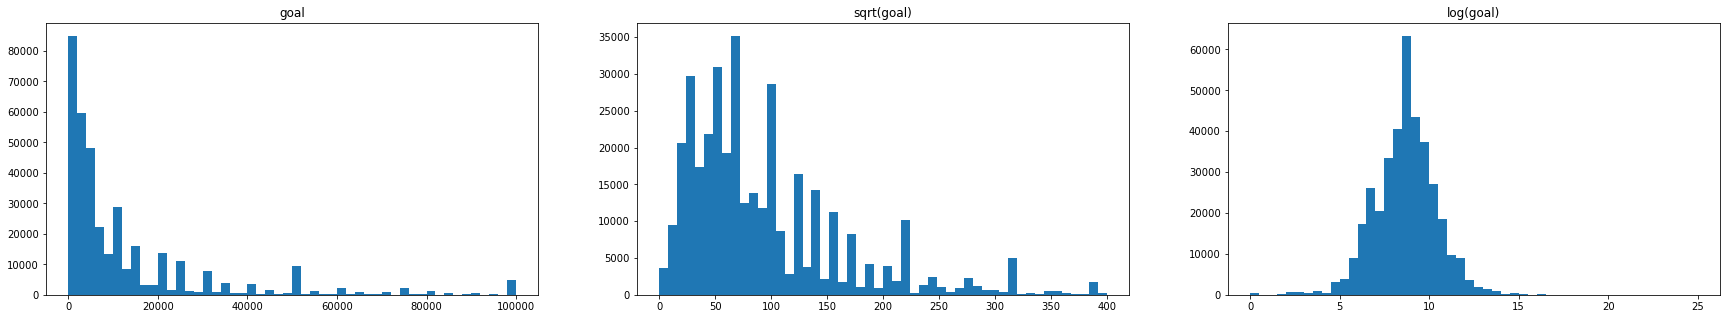

In [32]:
# DATA TRANSFORMATION
fig, axs = plt.subplots(ncols=3, figsize=(30,5))

# show transformations on goal data
axs[0].set_title("goal")
axs[0].hist(data.goal, range=(0, 100000), bins=50)

axs[1].set_title("sqrt(goal)")
axs[1].hist(np.sqrt(data.goal), range=(0, 400), bins=50)

axs[2].set_title("log(goal)")
axs[2].hist(np.log(data.goal), range=(0, 25), bins=50)

plt.show()

# logarithmic transformation on goal data
data['goal'] = np.log(data.goal)


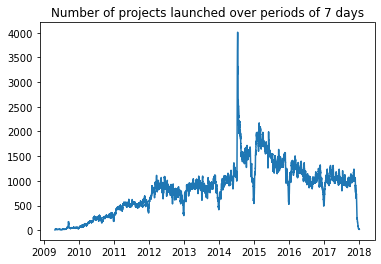

In [33]:
# DATA CREATION AND FEATURE ENGINEERING

# create competition feature
launches = pd.Series(data.index, index=data.launched, name="competition").sort_index()

competition = launches.rolling('7d').count() - 1

plt.plot(competition[7:])
plt.title("Number of projects launched over periods of 7 days")

competition.index = launches.values
competition = competition.reindex(data.index)
competition.head(10)

data['competition'] = competition



In [34]:
# DATA CREATION (FEATURE ENGINEERING)
# TODO: create feature that shows how many projects were launched in the past week
# TODO: create a better 'goal' feature, that uses Fixer.io API to convert the goal to current goal value, to account for inflation


# create titlelength feature
data['tlength'] = data['name'].str.len()

# create duration feature, value in days, gets rounded up
data['duration'] = (data['deadline'] - data['launched']) / np.timedelta64(1, 'D')
data['duration'] = data['duration'].round(0).astype(int)

# create launch features, month (1 to 12) and day of week (0 to 6)
data['lyear'] = pd.DatetimeIndex(data['launched']).year
data['lmonth'] = pd.DatetimeIndex(data['launched']).month
data['lday'] = pd.DatetimeIndex(data['launched']).dayofweek
data['lhour'] = pd.DatetimeIndex(data['launched']).hour

# create deadline features, month (1 to 12) and day of week (0 to 6)
data['dyear'] = pd.DatetimeIndex(data['deadline']).year
data['dmonth'] = pd.DatetimeIndex(data['deadline']).month
data['dday'] = pd.DatetimeIndex(data['deadline']).dayofweek 

data = data[['tlength', 'duration', 'goal', 'category_country', 'competition', 'lyear', 'lmonth', 'lday', 'lhour', 'dyear', 'dmonth', 'dday', 'outcome']].join(l_encoded)

In [35]:
# this code was just to calculate median duration, when the 1970 launch dates were removed from the data set
# the median turned out to be 30, so I just used that in the next section

# create duration feature, days are rounded up
# this is WITH the 1970 anomalies
# data['launched'] = pd.to_datetime(data['launched'])
# data['deadline'] = pd.to_datetime(data['deadline'])
# data['duration'] = (data['deadline'] - data['launched']) / np.timedelta64(1, 'D')
# data['duration'] = data['duration'].round(0).astype(int)

# data set without 1970 anomalies
# for some reason year == 1970 didn't work, so I do < 2000
# without_unix = data
# without_unix.drop(without_unix[pd.DatetimeIndex(without_unix.launched).year < 2000].index)
# print("Mean: ", without_unix['duration'].mean())
# print("Mode: ", without_unix['duration'].mode()[0])
#print("Median: ", without_unix['duration'].median())
# result: median is 30, we best use median since plot is right-skewed (see plot below)

# replace 1970 anomalies
# median_duration = without_unix['duration'].median()


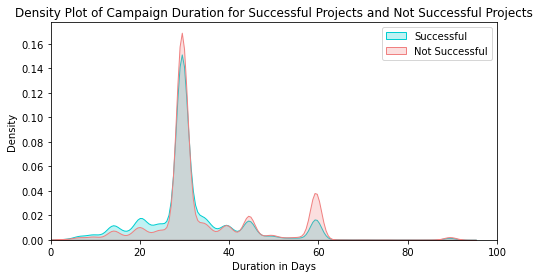

Mean:  33.53707611614212
Mode:  29
Median:  30.0


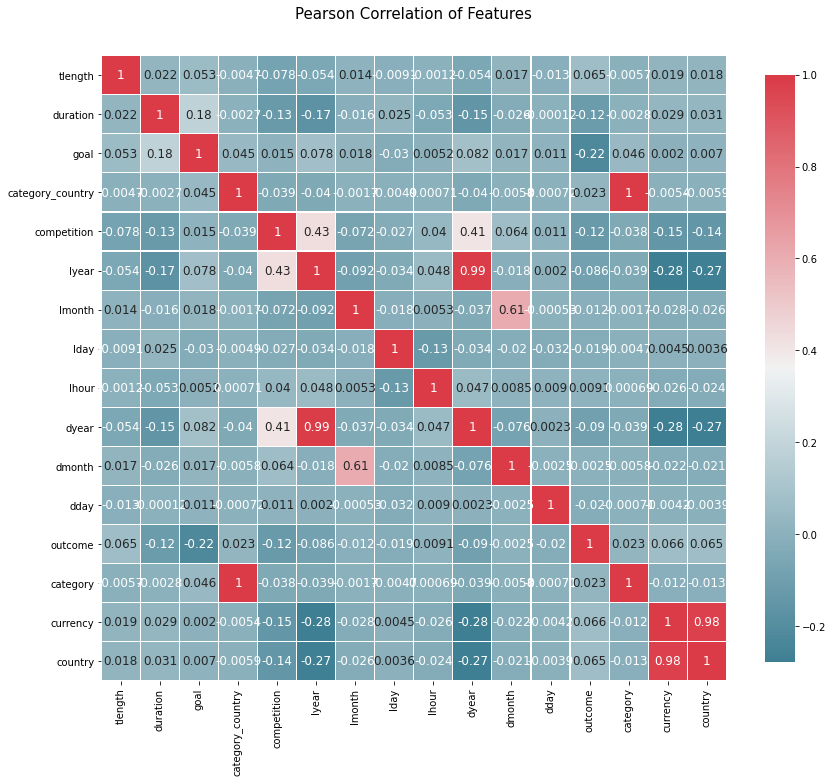

,outcome
tlength,0.065486
duration,0.117349
goal,0.223256
category_country,0.023355
competition,0.124624
lyear,0.085762
lmonth,0.011562
lday,0.018813
lhour,0.009070
dyear,0.089620


In [36]:
# DATA ANALYSIS AFTER FEATURE ENGINEERING
# TODO: do more data analysis here

# plot project duration
plt.figure(figsize=(8,4))
ax = sns.kdeplot(data['duration'][data.outcome == 1], color="darkturquoise", shade=True)
sns.kdeplot(data['duration'][data.outcome == 0], color="lightcoral", shade=True)
plt.legend(['Successful', 'Not Successful'])
plt.title('Density Plot of Campaign Duration for Successful Projects and Not Successful Projects')
ax.set(xlabel='Duration in Days')

# maximum project duration is 92 days
plt.xlim(0,100)
plt.show()

# print statistical data
print("Mean: ", data['duration'].mean())
print("Mode: ", data['duration'].mode()[0])
print("Median: ", data['duration'].median())

# correlations
fig, ax = plt.subplots(figsize=(14,12))

fig = sns.heatmap(
    data.corr(),
    cmap = sns.diverging_palette(220, 10, as_cmap=True),
    square=True,
    cbar_kws={'shrink':.9},
    ax=ax,
    annot=True,
    linewidths=0.1, vmax=1.0, linecolor='white',
    annot_kws={'fontsize':12}
)

plt.title('Pearson Correlation of Features', y=1.05, size=15)
plt.show()

data.corr().abs()[['outcome']]

In [37]:
# LightGBM
# Tree-based model that typically provides the best performance, even compared to XGBoost. It's also relatively fast to train.

import lightgbm as lgb
from sklearn import metrics

valid_fraction = 0.1
valid_size = int(len(data) * valid_fraction)

train = data[:-2 * valid_size]
valid = data[-2 * valid_size:-valid_size]
test = data[-valid_size:]

feature_cols = train.columns.drop('outcome')

x_train = lgb.Dataset(train[feature_cols], label=train['outcome'])
x_test = lgb.Dataset(valid[feature_cols], label=valid['outcome'])

param = {'num_leaves': 64, 'objective': 'binary'}
param['metric'] = 'auc'
bst = lgb.train(param, x_train, 1000, valid_sets=[x_test], early_stopping_rounds=10, verbose_eval=False)

ypred = bst.predict(test[feature_cols])

# evaluation
print("-"*60)
print('Aread Under Curve (AUC): %.2f%%' %(metrics.roc_auc_score(test['outcome'], ypred)*100))
print("-"*60)


------------------------------------------------------------
Aread Under Curve (AUC): 76.43%
------------------------------------------------------------


In [38]:
# PREPARE DATA FOR MODEL
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split

# make sure our data looks right
data.describe(include = 'all')

# x: predictors
# y: outcome

# get predictors and outcome
x_unscaled = data.drop('outcome', axis=1)
y = data.outcome # state is 0 or 1, so already scaled

# feature scaling/normalizing
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x_unscaled), columns=list(x_unscaled.columns))

# split data set int training and testing 
# test_size = proportion of dataset to include in the test split
# random_state = seed for random number generator that will shuffle the records
x_train, x_test, y_train, y_test = split(x, y, test_size=0.2, random_state=42)


------------------------------------------------------------


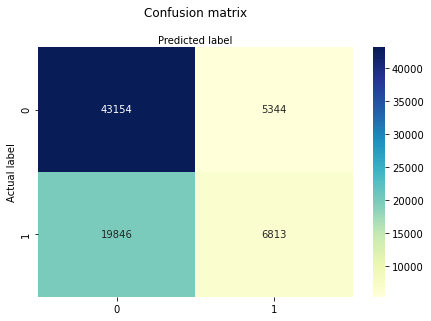

------------------------------------------------------------
Accuracy: 66.48%
Precision: 56.04%
Recall: 25.56%
------------------------------------------------------------
Logistic regression score for training set: 66.39%
Logistic regression score for test set: 66.48%
------------------------------------------------------------
Classification report:
              precision    recall  f1-score   support

           0       0.68      0.89      0.77     48498
           1       0.56      0.26      0.35     26659

    accuracy                           0.66     75157
   macro avg       0.62      0.57      0.56     75157
weighted avg       0.64      0.66      0.62     75157

------------------------------------------------------------
ROC curve:


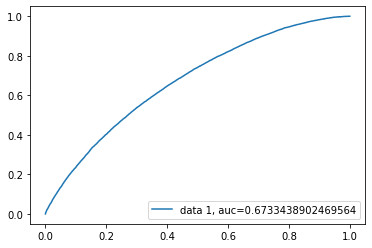

Test AUC score: 0.6733438902469564
------------------------------------------------------------


In [39]:
# LOGISTIC REGRESSION
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import metrics

# instantiate logistic regression model
model = LogisticRegression()

# fit the model with the data
model.fit(x_train,y_train)

# make predictions
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

# create confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_pred_test)
cnf_matrix

# visualize confusion matrix
print("-"*60)
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()
print("-"*60)

# evaluation
print('Accuracy: %.2f%%' %(metrics.accuracy_score(y_test, y_pred_test)*100))
print('Precision: %.2f%%' %(metrics.precision_score(y_test, y_pred_test)*100))
print('Recall: %.2f%%' %(metrics.recall_score(y_test, y_pred_test)*100))
print("-"*60)

# logistic regression scores
print('Logistic regression score for training set: %.2f%%' %(round(model.score(x_train, y_train),5)*100))
print('Logistic regression score for test set: %.2f%%' %(round(model.score(x_test, y_test),5)*100))
print("-"*60)

# classification report
print("Classification report:")
print(classification_report(y_test, y_pred_test))
print("-"*60)

# ROC curve
print("ROC curve:")
y_pred_proba = model.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()
print(f"Test AUC score: {auc}")
print("-"*60)



In [17]:
# NAIVE BAYES ALGORITHM
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn import metrics

# instantiate logistic regression model
model = GaussianNB()

# fit the model with the data
model.fit(x_train,y_train)

# make predictions
predict_test = model.predict(x_test)

# evaluation
print("-"*60)
print('Accuracy: %.2f%%' %(metrics.accuracy_score(y_test, predict_test)*100))
print('Precision: %.2f%%' %(metrics.precision_score(y_test, predict_test)*100))
print('Recall: %.2f%%' %(metrics.recall_score(y_test, predict_test)*100))
print("-"*60)


------------------------------------------------------------
Accuracy: 64.68%
Precision: 50.25%
Recall: 44.61%
------------------------------------------------------------


In [44]:
# NEURAL NETWORK
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential()

model.add(layers.Dense(2, activation="relu"))
model.add(layers.Dense(3, activation="relu"))
model.add(layers.Dense(4))

#model.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy'])
#model.fit(x_train, y_train, batch_size=32, epochs=50)

#model.summary()

#y_pred = model.predict_classes(x_test)
#print(metrics.accuracy_score(y_test, y_pred))

